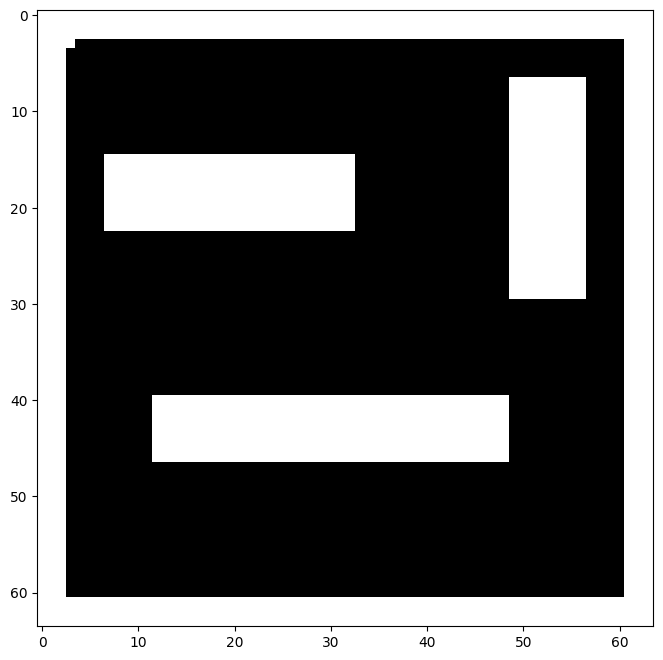

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import networkx as nx

from coppeliasim_zmqremoteapi_client import RemoteAPIClient 


def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('../mapas_meus/teste1_invertido.png')
#img = 1 - mpimg.imread('img/maze.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([64, 64]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 1

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        


✅ RRT: caminho encontrado em iteração 70, tempo 0.00s


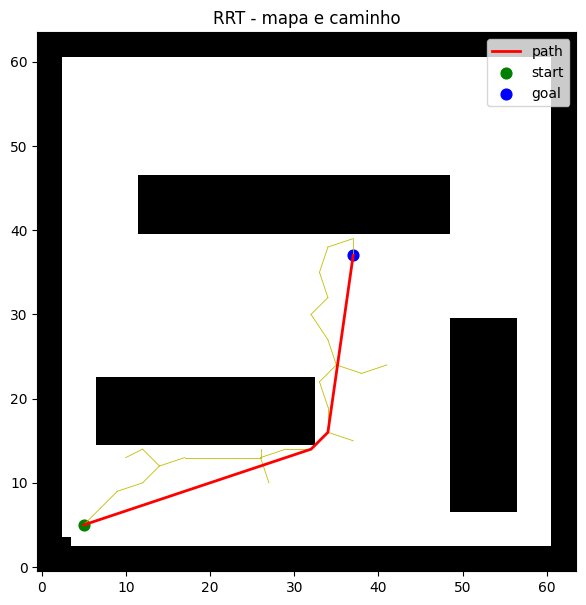

Caminho encontrado com 4 nós.
Start node (px): (5, 5) World: (-4.21875, 4.21875)
Goal node (px): (37, 37) World: (0.78125, -0.78125)
✅ Simulação iniciada; seguindo waypoints...
✅ Waypoint 0 alcançado (4 total).
✅ Waypoint 1 alcançado (4 total).
✅ Waypoint 2 alcançado (4 total).
✅ Waypoint 3 alcançado (4 total).
🎯 Execução finalizada.
Posição final: [0.8397159858082223, -0.7292964178624344, 0.03885562632668569]
Orientação final (deg): [-1.25101236e-02 -6.88004333e-02 -1.24371778e+02]


In [7]:
"""
RRT planner para grid 64x64.
Entrada:
 - grid: np.array(rows,cols) com 0=livre, 1=ocupado
 - start: (row, col)
 - goal:  (row, col)
Saída:
 - pos: dict {idx: (x_px, y_px)}  (x_px=coluna, y_px=linha)
 - path: list de índices na ordem do caminho
"""

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time

# se quiser integrar ao CoppeliaSim (opcional)
try:
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    COPPELIA_AVAILABLE = True
except Exception:
    COPPELIA_AVAILABLE = False

class Node:
    def __init__(self, coord, parent=None):
        # coord: (row, col)
        self.coord = coord
        self.parent = parent

def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def sample_free(rows, cols, goal, goal_sample_rate=0.05):
    """
    Amostragem: com probabilidade goal_sample_rate retorna goal (bias),
    caso contrário retorna amostra aleatória no grid.
    """
    if random.random() < goal_sample_rate:
        return goal
    return (random.randint(0, rows-1), random.randint(0, cols-1))

def nearest(nodes, sample):
    """
    Retorna índice do nó mais próximo na lista `nodes` para a amostra `sample`.
    nodes: lista de Node
    sample: (row,col)
    """
    best_idx = 0
    best_d = float('inf')
    for i, n in enumerate(nodes):
        d = dist(n.coord, sample)
        if d < best_d:
            best_d = d
            best_idx = i
    return best_idx

def steer(from_coord, to_coord, step_size):
    """
    Retorna um novo ponto partindo de `from_coord` na direção de `to_coord`
    com distância máxima step_size (em células). Se a distância é menor que
    step_size, retorna to_coord.
    """
    d = dist(from_coord, to_coord)
    if d <= step_size:
        return to_coord
    else:
        theta = math.atan2(to_coord[0]-from_coord[0], to_coord[1]-from_coord[1])  # note: row ~ y
        # deslocamento em row/col: usamos sin/cos adequadamente
        new_r = from_coord[0] + step_size * math.sin(theta)
        new_c = from_coord[1] + step_size * math.cos(theta)
        # arredondar para inteiro de célula mais próximo
        return (int(round(new_r)), int(round(new_c)))

def collision_free(grid, a, b, step=0.5):
    """
    Verifica colisão entre dois pontos a e b (cada um (row,col)).
    Percorre o segmento em passos e verifica se algum ponto cai em célula ocupada.
    step: resolução de amostragem (em células)
    """
    a_r, a_c = a
    b_r, b_c = b
    length = dist(a, b)
    if length == 0:
        # verificar célula
        r, c = int(round(a_r)), int(round(a_c))
        if 0 <= r < grid.shape[0] and 0 <= c < grid.shape[1]:
            return grid[r, c] == 0
        return False
    n_samples = max(int(math.ceil(length / step)), 1)
    for i in range(n_samples+1):
        t = i / n_samples
        r = a_r + (b_r - a_r) * t
        c = a_c + (b_c - a_c) * t
        ri, ci = int(round(r)), int(round(c))
        if not (0 <= ri < grid.shape[0] and 0 <= ci < grid.shape[1]):
            return False
        if grid[ri, ci] == 1:
            return False
    return True

def reconstruct_path(node):
    path = []
    cur = node
    while cur is not None:
        path.append(cur.coord)
        cur = cur.parent
    return path[::-1]

def rrt_planner(grid, start, goal,
                max_iter=10000,
                step_size=3,
                goal_sample_rate=0.05,
                connect_circle_dist=10,
                visualize=True,
                smoothing_iters=100):
    """
    RRT básico (não RRT*). Retorna pos, path_coords (lista de (row,col)) e nodes.
    """
    rows, cols = grid.shape
    if grid[start[0], start[1]] == 1:
        raise RuntimeError("Start dentro de obstáculo")
    if grid[goal[0], goal[1]] == 1:
        raise RuntimeError("Goal dentro de obstáculo")

    nodes = [Node(start, parent=None)]

    found = False
    goal_node = None
    start_time = time.time()

    for it in range(max_iter):
        sample = sample_free(rows, cols, goal, goal_sample_rate=goal_sample_rate)
        nearest_idx = nearest(nodes, sample)
        nearest_node = nodes[nearest_idx]
        new_coord = steer(nearest_node.coord, sample, step_size)

        # checar limites e colisões
        if not (0 <= new_coord[0] < rows and 0 <= new_coord[1] < cols):
            continue
        if grid[new_coord[0], new_coord[1]] == 1:
            continue
        if not collision_free(grid, nearest_node.coord, new_coord, step=0.5):
            continue

        new_node = Node(new_coord, parent=nearest_node)
        nodes.append(new_node)

        # checar se chegamos no goal (dentro de step_size ou colisão-free para goal)
        if dist(new_coord, goal) <= step_size and collision_free(grid, new_coord, goal, step=0.5):
            goal_node = Node(goal, parent=new_node)
            nodes.append(goal_node)
            found = True
            print(f"✅ RRT: caminho encontrado em iteração {it}, tempo {time.time()-start_time:.2f}s")
            break

    if not found:
        print("⚠️ RRT: não encontrou caminho dentro do número máximo de iterações.")
        return None, None, nodes

    # reconstruir caminho
    path_coords = reconstruct_path(goal_node)

    # smoothing (short-cut): tenta juntar pares distantes se colisão-free
    def shortcut(path_coords, iters=smoothing_iters):
        if len(path_coords) <= 2:
            return path_coords
        for _ in range(iters):
            if len(path_coords) <= 2:
                break
            i = random.randint(0, len(path_coords)-2)
            j = random.randint(i+1, len(path_coords)-1)
            if j == i+1:
                continue
            if collision_free(grid, path_coords[i], path_coords[j], step=0.5):
                # remove os pontos entre i e j
                new_path = path_coords[:i+1] + path_coords[j:]
                path_coords = new_path
        return path_coords

    path_coords = shortcut(path_coords, smoothing_iters)

    # converter para pos (dict idx -> (x_px, y_px)) com x_px = coluna, y_px = linha
    pos = {}
    path = []
    for i, (r, c) in enumerate(path_coords):
        pos[i] = (int(c), int(r))
        path.append(i)

    if visualize:
        plt.figure(figsize=(7,7))
        plt.title("RRT - mapa e caminho")
        plt.imshow(grid, origin='upper', cmap='gray_r')  # obstáculos em preto
        # plot tree
        for n in nodes:
            if n.parent is not None:
                y0, x0 = n.parent.coord
                y1, x1 = n.coord
                plt.plot([x0, x1], [y0, y1], '-y', linewidth=0.6)
        # plot path
        ys = [p[0] for p in path_coords]
        xs = [p[1] for p in path_coords]
        plt.plot(xs, ys, '-r', linewidth=2, label='path')
        plt.scatter([start[1]], [start[0]], c='green', s=60, label='start')
        plt.scatter([goal[1]], [goal[0]], c='blue', s=60, label='goal')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()

    return pos, path, nodes

# ============================
# Exemplo de execução (assume que `grid` já existe)
# ============================
# start e goal conforme solicitado
start = (5, 5)
goal  = (37, 37)

# Se você estiver executando este arquivo sozinho, descomente a parte abaixo que cria um exemplo de grid:
# # exemplo: grid de teste (comentado se você fornecer grid real)
# grid = np.zeros((64,64), dtype=int)
# # cria alguns obstáculos de exemplo
# grid[20:30, 20:40] = 1
# grid[10:12, 40:50] = 1
# grid[40:45, 5:20] = 1

# RRT
pos, path, nodes = rrt_planner(grid, start, goal,
                               max_iter=12000,
                               step_size=3,
                               goal_sample_rate=0.05,
                               visualize=True,
                               smoothing_iters=200)

if pos is None:
    print("RRT falhou em encontrar caminho. Considere aumentar max_iter, step_size menor ou ajustar grid.")
else:
    print("Caminho encontrado com", len(path), "nós.")
    # pos e path estão prontos no formato compatível com seu script anterior (usar pixel_to_world)
    # Exemplo: converter para coordenadas do mundo (se você tem pixel_to_world)
    def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
        scale = world_size / img_size
        x_world = (x_px - img_size/2) * scale
        y_world = -(y_px - img_size/2) * scale
        return x_world, y_world

    pos_world = {node: pixel_to_world(x, y, img_size=64, world_size=10) for node, (x, y) in pos.items()}

    # imprimir primeiro/ultimo
    print("Start node (px):", pos[0], "World:", pos_world[0])
    print("Goal node (px):", pos[path[-1]], "World:", pos_world[path[-1]])

if not COPPELIA_AVAILABLE:
    print("⚠️ CoppeliaSim não disponível. `pos` e `path` gerados.")
    print("nós:", len(path))
    print("exemplo pos[0]:", pos[0], "pos_world[0]:", pos_world[0])
else:
    client = RemoteAPIClient()
    sim = client.require("sim")

    try:
        sim.setStepping(True)
    except Exception:
        pass

    robotname = 'robotino'
    try:
        robotHandle = sim.getObject('/' + robotname)
    except Exception:
        try:
            robotHandle = sim.getObjectHandle('/' + robotname)
        except Exception as e:
            raise RuntimeError("Não foi possível obter handle do robô no CoppeliaSim. Erro: " + str(e))

    # handles das rodas (tenta getObject, senão getObjectHandle)
    try:
        wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
        wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
        wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')
    except Exception:
        wheel1 = sim.getObjectHandle(f'/{robotname}/wheel0_joint')
        wheel2 = sim.getObjectHandle(f'/{robotname}/wheel1_joint')
        wheel3 = sim.getObjectHandle(f'/{robotname}/wheel2_joint')

    # Parâmetros do robô (mesmos do seu código)
    L = 0.135
    r = 0.040
    Mdir = np.array([
        [-r/np.sqrt(3),     0,        r/np.sqrt(3)],
        [r/3,            (-2*r)/3,    r/3],
        [r/(3*L),         r/(3*L),    r/(3*L)]
    ])

    # posição inicial = primeiro nó do path
    start_node = path[0]
    start_px = pos[start_node]   # (x_px,y_px)
    start_pos_xy = pixel_to_world(start_px[0], start_px[1], img_size=64, world_size=10)
    start_pos = [start_pos_xy[0], start_pos_xy[1], 0.04]
    start_ori = [0, 0, np.deg2rad(90)]

    # garantir sim parada antes de setar
    try:
        if sim.getSimulationState() != 0:
            sim.stopSimulation()
            time.sleep(1)
    except Exception:
        pass

    # setar posição e orientação
    try:
        sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
        sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)
        sim.step()
    except Exception as e:
        print("⚠️ Não foi possível setar posição/orientação diretamente:", e)

    # iniciar simulação
    try:
        sim.startSimulation()
        sim.step()
    except Exception as e:
        print("⚠️ Erro ao iniciar simulação:", e)

    print("✅ Simulação iniciada; seguindo waypoints...")

    # criar lista de waypoints (em metros)
    waypoints = [pos_world[node] for node in path]
    target_index = 0
    tolerance = 0.08  # metros
    max_time = 300  # tempo máximo de execução em segundos
    t0 = time.time()

    # obter posição inicial do simulador
    try:
        pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
        q = np.array([pos_sim[0], pos_sim[1], np.deg2rad(90)])
    except Exception:
        q = np.array([start_pos[0], start_pos[1], np.deg2rad(90)])

    # loop principal de seguimento de waypoints
    while target_index < len(waypoints):
        if time.time() - t0 > max_time:
            print("⏱️ Tempo máximo de execução atingido; interrompendo.")
            break

        target = np.array(waypoints[target_index])
        try:
            pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
            q[0], q[1] = pos_sim[0], pos_sim[1]
        except Exception:
            pass

        erro = target - q[:2]
        dist_err = np.linalg.norm(erro)

        ang_desejado = np.arctan2(erro[1], erro[0])
        erro_ang = np.arctan2(np.sin(ang_desejado - q[2]), np.cos(ang_desejado - q[2]))

        # controladores P
        v_linear = 0.4 * dist_err
        v_angular = 1.5 * erro_ang
        v_linear = np.clip(v_linear, -0.3, 0.3)
        v_angular = np.clip(v_angular, -1.0, 1.0)

        qdot = np.array([v_linear * np.cos(q[2]), v_linear * np.sin(q[2]), v_angular])
        try:
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot
        except Exception:
            u = np.array([v_linear, v_linear, v_linear])

        # enviar velocidades para as rodas
        try:
            sim.setJointTargetVelocity(wheel1, float(u[0]))
            sim.setJointTargetVelocity(wheel2, float(u[1]))
            sim.setJointTargetVelocity(wheel3, float(u[2]))
        except Exception as e:
            print("⚠️ Erro ao setar velocidades:", e)

        # integração simples do estado
        try:
            dt = sim.getSimulationTimeStep()
        except Exception:
            dt = 0.05
        q = q + (Rz(q[2]) @ Mdir @ u) * dt

        try:
            sim.step()
        except Exception:
            time.sleep(dt)

        if dist_err < tolerance:
            print(f"✅ Waypoint {target_index} alcançado ({len(waypoints)} total).")
            target_index += 1

    # parar as rodas
    for w in [wheel1, wheel2, wheel3]:
        try:
            sim.setJointTargetVelocity(w, 0)
        except:
            pass

    print("🎯 Execução finalizada.")
    try:
        sim.stopSimulation()
    except:
        pass

    try:
        posf = sim.getObjectPosition(robotHandle, sim.handle_world)
        orif = sim.getObjectOrientation(robotHandle, sim.handle_world)
        print("Posição final:", posf)
        print("Orientação final (deg):", np.rad2deg(orif))
    except:
        pass

# ============================
# Fim do script
# ============================

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import networkx as nx

from coppeliasim_zmqremoteapi_client import RemoteAPIClient 

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

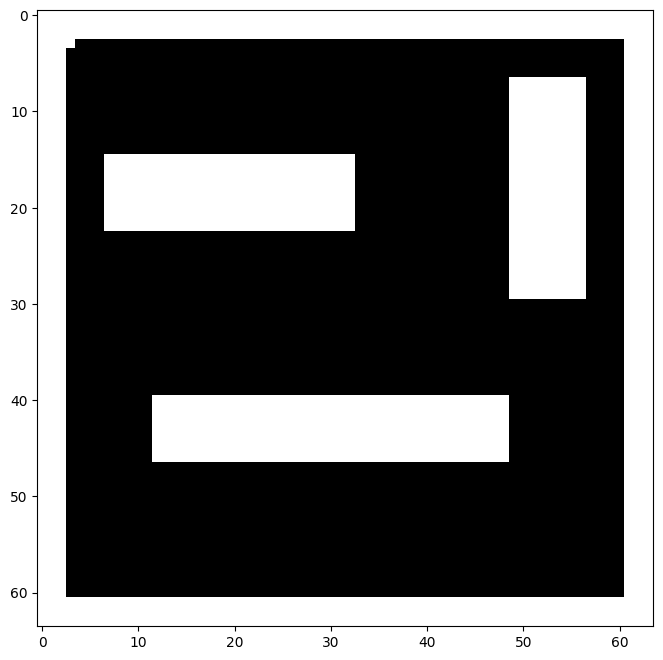

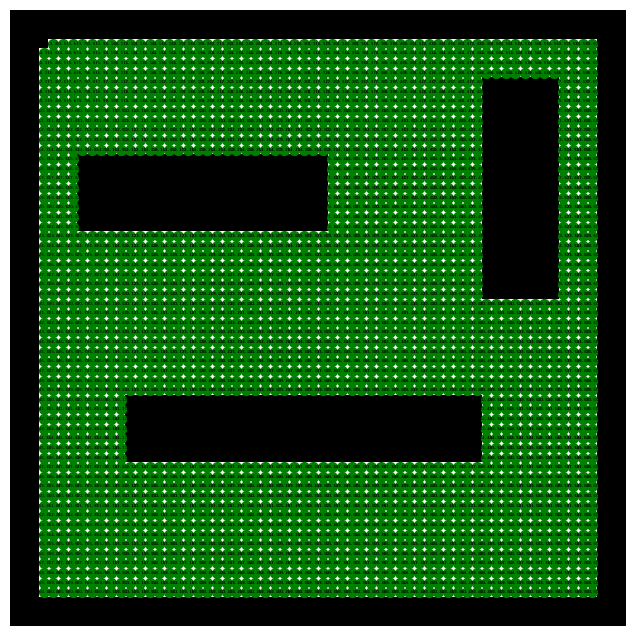

In [4]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

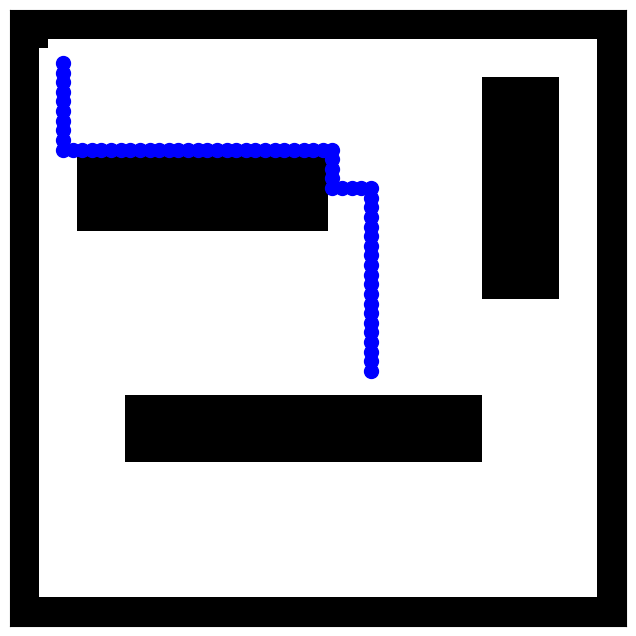

In [5]:
# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

# Cave
start_node =  (5, 5)
end_node = (37, 37)


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

In [ ]:
print(path)
print(G)
print(pos)

In [ ]:
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size/2) * scale
    y_world = (y_px - img_size/2) * scale  # invertido porque o eixo Y da imagem cresce para baixo
    return x_world, y_world


In [ ]:
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    """
    Converte coordenadas de pixel (imagem) para coordenadas do CoppeliaSim (metros).
    """
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size/2) * scale
    y_world = (y_px - img_size/2) * scale  # invertido porque o eixo Y da imagem cresce para baixo
    return x_world, y_world



# Connect to the CoppeliaSim server
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Handle para o ROBÔ
robotname = 'robotino'
robotHandle = sim.getObject('/' + robotname)


pos_world = {}
for node, (x_px, y_px) in pos.items():
    pos_world[node] = pixel_to_world(x_px, y_px, img_size=64, world_size=10)



start_pos = pixel_to_world(5, 5)
start_pos = [start_pos[0],start_pos[1],0.04]

# Orientação inicial (em radianos)
# [roll, pitch, yaw]
start_ori = [0, 0, np.deg2rad(90)]

# Aplicar no simulador
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
# sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)



# Handle para as juntas das RODAS
wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')

# Dados Robotino
L = 0.135   # Metros
r = 0.040   # Metros
           
# Cinemática Direta
Mdir = np.array([[-r/np.sqrt(3),     0,        r/np.sqrt(3)], 
                 [r/3,            (-2*r)/3,    r/3], 
                 [r/(3*L),         r/(3*L),    r/(3*L)]])


# Configuração inicial (x, y, w)
q = np.array([0, 0, 0.5])

# # Lembrar de habilitar o 'Real-time mode'    
# # Parar a simulação se estiver executando
# initial_sim_state = sim.getSimulationState()
# if initial_sim_state != 0:
#     sim.stopSimulation()
#     time.sleep(1)

# # Inicia a simulação
# sim.startSimulation()
# sim.step()

# print("Starting robot path-following...")

# # Converter o caminho (lista de nós) em posições no mundo
# waypoints = [pos_world[node] for node in path]

# # Obter posição inicial real no simulador
# pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
# q = np.array([pos_sim[0], pos_sim[1], 0])  # x, y, yaw inicial (yaw = 0 por simplicidade)

# target_index = 0
# tolerance = 0.1  # tolerância em metros para considerar que chegou



# 1. Definir o ponto de partida a partir do PRIMEIRO nó do caminho
start_node = path[0]
start_pos_world = pos_world[start_node]

# Posição inicial (x, y, z)
# O Z=0.04 é a altura do seu robô, mantenha-o.
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.04]

# Orientação inicial (roll, pitch, yaw) em radianos
# Yaw (rotação em Z) de 90 graus para começar virado para "cima" no mapa, por exemplo.
start_ori_sim = [0, 0, np.deg2rad(90)] 

# Para a simulação se estiver rodando, garantindo um reinício limpo
if sim.getSimulationState() != sim.simulation_stopped:
    sim.stopSimulation()
    # Espera a simulação parar completamente
    while sim.getSimulationState() != sim.simulation_stopped:
        time.sleep(0.1)

# Inicia a simulação
sim.startSimulation()

# 2. Aplicar a posição E a orientação no robô no simulador
print(f"Definindo posição inicial do robô em: {start_pos_sim}")
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
print(f"Definindo orientação inicial do robô em (rad): {start_ori_sim}")
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)

# Avança um passo na simulação para que as mudanças tenham efeito
sim.step()

# 3. Inicializar o vetor de estado do controlador (q) COM OS MESMOS VALORES
#    Agora 'q' reflete exatamente a pose inicial do robô no mundo.
q = np.array([start_pos_sim[0], start_pos_sim[1], start_ori_sim[2]])

print("Iniciando o seguimento do caminho...")

# Converter o caminho (lista de nós) em posições no mundo
waypoints = [pos_world[node] for node in path]

target_index = 0
tolerance = 0.1  # Tolerância em metros para considerar que chegou




while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]
    
    # calcular erro
    erro = target - q[:2]
    dist = np.linalg.norm(erro)
    
    # calcular ângulo para o alvo
    angulo_desejado = np.arctan2(erro[1], erro[0])
    erro_angulo = angulo_desejado - q[2]
    erro_angulo = np.arctan2(np.sin(erro_angulo), np.cos(erro_angulo))  # normalizar

    # controlador simples P
    v_linear = 0.4 * dist
    v_angular = 1.5 * erro_angulo

    # limitar velocidades
    v_linear = np.clip(v_linear, -0.3, 0.3)
    v_angular = np.clip(v_angular, -1.0, 1.0)

    # cinemática inversa
    qdot = np.array([v_linear * np.cos(q[2]), v_linear * np.sin(q[2]), v_angular])
    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
    u = Minv @ qdot

    # enviar velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2]) 
    
    # atualizar posição
    dt = sim.getSimulationTimeStep()
    q = q + (Rz(q[2]) @ Mdir @ u)*dt
    sim.step()
    
    if dist < tolerance:
        print(f"✅ Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1

# parar o robô
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)
print("🎯 Caminho concluído!")

sim.stopSimulation()
print('Program ended')

print("Stopping robot...")
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)

# print('CALC Pos: ', sim_time, q[:2], np.rad2deg(q[2]))
  
pos = sim.getObjectPosition(robotHandle, sim.handle_world)
print('SIM Pos: ', pos)
ori = sim.getObjectOrientation(robotHandle, sim.handle_world)
print('SIM Ori: ', np.rad2deg(ori))
    
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')

In [ ]:
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# ============================================================
# Conversão de coordenadas
# ============================================================
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size / 2) * scale
    y_world = (y_px - img_size / 2) * scale
    return x_world, y_world


def Rz(theta):
    """Matriz de rotação 2D (para converter mundo ↔ corpo)."""
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])


# ============================================================
# Conexão com o CoppeliaSim
# ============================================================
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Handle do robô
robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

# ============================================================
# Conversão das posições dos nós para coordenadas do mundo
# ============================================================
pos_world = {node: pixel_to_world(x_px, y_px, 64, 10) for node, (x_px, y_px) in pos.items()}

# ============================================================
# Dados do robô
# ============================================================
L = 0.135  # distância do centro às rodas (m)
r = 0.040  # raio das rodas (m)

# Cinemática direta do Robotino (holonômico de 3 rodas)
Mdir = np.array([
    [-np.sin(np.deg2rad(0)),    np.cos(np.deg2rad(0)),    L],
    [-np.sin(np.deg2rad(120)),  np.cos(np.deg2rad(120)),  L],
    [-np.sin(np.deg2rad(240)),  np.cos(np.deg2rad(240)),  L]
]) * (1 / r)

# Inversa da cinemática direta
Minv = np.linalg.pinv(Mdir)

# ============================================================
# Handles das juntas das rodas
# ============================================================
wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')

# ============================================================
# Configuração inicial
# ============================================================
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.04]
start_ori_sim = [0, 0, np.deg2rad(90)]  # orientação fixa

# Reinicia simulação
if sim.getSimulationState() != sim.simulation_stopped:
    sim.stopSimulation()
    while sim.getSimulationState() != sim.simulation_stopped:
        time.sleep(0.1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
yaw = start_ori_sim[2]
q = np.array([start_pos_sim[0], start_pos_sim[1], yaw])

print("Iniciando o seguimento de caminho (modo holonômico sem rotação)...")

# ============================================================
# Seguimento do caminho
# ============================================================
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.1

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.6 * erro[0]
    vy_world = 0.6 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-yaw) @ np.array([vx_world, vy_world])
    vx_body, vy_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])
    u = Mdir @ qdot  # usa cinemática direta para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"✅ Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1

# ============================================================
# Encerramento
# ============================================================
print("🎯 Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos)
sim.stopSimulation()
print("Program ended.")


In [9]:
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# ============================================================
# Conversão de coordenadas
# ============================================================
def pixel_to_world(x_px, y_px, img_size=64, world_size=10):
    scale = world_size / img_size  # m/pixel
    x_world = (x_px - img_size / 2) * scale
    y_world = (y_px - img_size / 2) * scale
    return x_world, y_world


def Rz(theta):
    """Matriz de rotação 2D (para converter mundo ↔ corpo)."""
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])


# ============================================================
# Conexão com o CoppeliaSim
# ============================================================
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Handle do robô
robotname = 'robotino'
robotHandle = sim.getObject(f'/{robotname}')

# ============================================================
# Conversão das posições dos nós para coordenadas do mundo
# ============================================================
pos_world = {node: pixel_to_world(x_px, y_px, 64, 10) for node, (x_px, y_px) in pos.items()}

# ============================================================
# Dados do robô
# ============================================================
L = 0.135  # distância do centro às rodas (m)
r = 0.040  # raio das rodas (m)

# Cinemática direta do Robotino (holonômico de 3 rodas)
Mdir = np.array([
    [-np.sin(np.deg2rad(0)),    np.cos(np.deg2rad(0)),    L],
    [-np.sin(np.deg2rad(120)),  np.cos(np.deg2rad(120)),  L],
    [-np.sin(np.deg2rad(240)),  np.cos(np.deg2rad(240)),  L]
]) * (1 / r)

# Inversa da cinemática direta
Minv = np.linalg.pinv(Mdir)

# ============================================================
# Handles das juntas das rodas
# ============================================================
wheel1 = sim.getObject(f'/{robotname}/wheel0_joint')
wheel2 = sim.getObject(f'/{robotname}/wheel1_joint')
wheel3 = sim.getObject(f'/{robotname}/wheel2_joint')

# ============================================================
# Configuração inicial
# ============================================================
start_node = path[0]
start_pos_world = pos_world[start_node]
start_pos_sim = [start_pos_world[0], start_pos_world[1], 0.04]
start_ori_sim = [0, 0, np.deg2rad(90)]  # orientação fixa

# Reinicia simulação
if sim.getSimulationState() != sim.simulation_stopped:
    sim.stopSimulation()
    while sim.getSimulationState() != sim.simulation_stopped:
        time.sleep(0.1)

sim.startSimulation()
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos_sim)
sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori_sim)
sim.step()

# Estado inicial
yaw = start_ori_sim[2]
q = np.array([start_pos_sim[0], start_pos_sim[1], yaw])

print("Iniciando o seguimento de caminho (modo holonômico sem rotação)...")

# ============================================================
# Seguimento do caminho
# ============================================================
waypoints = [pos_world[node] for node in path]
target_index = 0
tolerance = 0.2

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]

    # Erro no referencial do mundo
    erro = target - q[:2]
    dist = np.linalg.norm(erro)

    # Controlador proporcional
    vx_world = 0.6 * erro[0]
    vy_world = 0.6 * erro[1]

    # Limita velocidades
    vx_world = np.clip(vx_world, -0.3, 0.3)
    vy_world = np.clip(vy_world, -0.3, 0.3)

    # Converte velocidade do mundo → corpo (mantendo orientação fixa)
    v_body = Rz(-yaw) @ np.array([vx_world, vy_world])
    vx_body, vy_body = v_body
    w = 0.0  # sem rotação

    # Calcula velocidades das rodas
    qdot = np.array([vx_body, vy_body, w])
    u = Mdir @ qdot  # usa cinemática direta para gerar rodas

    # Envia velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2])

    # Avança um passo
    sim.step()

    # Verifica se chegou
    if dist < tolerance:
        print(f"✅ Chegou em {path[target_index]} -> indo para o próximo ponto")
        target_index += 1

# ============================================================
# Encerramento
# ============================================================
print("🎯 Caminho concluído! Parando robô...")
for w in [wheel1, wheel2, wheel3]:
    sim.setJointTargetVelocity(w, 0)

pos = sim.getObjectPosition(robotHandle, sim.handle_world)
print("Posição final (SIM):", pos)
sim.stopSimulation()
print("Program ended.")


Iniciando o seguimento de caminho (modo holonômico sem rotação)...
✅ Chegou em (5, 5) -> indo para o próximo ponto
✅ Chegou em (6, 5) -> indo para o próximo ponto
✅ Chegou em (7, 5) -> indo para o próximo ponto
✅ Chegou em (8, 5) -> indo para o próximo ponto
✅ Chegou em (9, 5) -> indo para o próximo ponto
✅ Chegou em (10, 5) -> indo para o próximo ponto
✅ Chegou em (11, 5) -> indo para o próximo ponto
✅ Chegou em (12, 5) -> indo para o próximo ponto
✅ Chegou em (13, 5) -> indo para o próximo ponto
✅ Chegou em (14, 5) -> indo para o próximo ponto
✅ Chegou em (14, 6) -> indo para o próximo ponto
✅ Chegou em (14, 7) -> indo para o próximo ponto
✅ Chegou em (14, 8) -> indo para o próximo ponto
✅ Chegou em (14, 9) -> indo para o próximo ponto
✅ Chegou em (14, 10) -> indo para o próximo ponto
✅ Chegou em (14, 11) -> indo para o próximo ponto
✅ Chegou em (14, 12) -> indo para o próximo ponto
✅ Chegou em (14, 13) -> indo para o próximo ponto
✅ Chegou em (14, 14) -> indo para o próximo ponto
✅ 

In [ ]:

# Connect to the CoppeliaSim server
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

# Handle para o ROBÔ
robotname = 'robotino'
robotHandle = sim.getObject('/' + robotname)


# Coordenadas desejadas no mundo [x, y, z]
start_pos = [-3, 4, 0.04]  # em metros

# Orientação inicial (em radianos)
# [roll, pitch, yaw]
start_ori = [0, 0, np.deg2rad(90)]

# Aplicar no simulador
sim.setObjectPosition(robotHandle, sim.handle_world, start_pos)
# sim.setObjectOrientation(robotHandle, sim.handle_world, start_ori)



# Handle para as juntas das RODAS
wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')

# Dados Robotino
L = 0.135   # Metros
r = 0.040   # Metros
           
# Cinemática Direta
Mdir = np.array([[-r/np.sqrt(3),     0,        r/np.sqrt(3)], 
                 [r/3,            (-2*r)/3,    r/3], 
                 [r/(3*L),         r/(3*L),    r/(3*L)]])


# Configuração inicial (x, y, w)
q = np.array([0, 0, 0.5])

# Lembrar de habilitar o 'Real-time mode'    
# Parar a simulação se estiver executando
initial_sim_state = sim.getSimulationState()
if initial_sim_state != 0:
    sim.stopSimulation()
    time.sleep(1)

# Inicia a simulação
sim.startSimulation()
sim.step()




# --- após iniciar a simulação ---
print("Starting robot path-following...")

# Transformar o caminho (lista de nós) em lista de coordenadas
waypoints = [pos[node] for node in path]

# posição inicial no simulador
pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
q = np.array([pos_sim[0], pos_sim[1], 0])  # x, y, yaw inicial

target_index = 0
tolerance = 0.1  # erro de posição aceitável (m)

while target_index < len(waypoints):
    target = np.array(waypoints[target_index])
    pos_sim = sim.getObjectPosition(robotHandle, sim.handle_world)
    q[:2] = pos_sim[:2]
    
    # calcular erro
    erro = target - q[:2]
    dist = np.linalg.norm(erro)
    
    # calcular ângulo para o alvo
    angulo_desejado = np.arctan2(erro[1], erro[0])
    erro_angulo = angulo_desejado - q[2]
    
    # normalizar ângulo para [-pi, pi]
    erro_angulo = np.arctan2(np.sin(erro_angulo), np.cos(erro_angulo))
    
    # velocidades proporcionais simples
    v_linear = 0.3 * dist
    v_angular = 1.5 * erro_angulo
    
    # limitar velocidades
    v_linear = np.clip(v_linear, -0.3, 0.3)
    v_angular = np.clip(v_angular, -1.0, 1.0)
    
    # cinemática inversa
    qdot = np.array([v_linear * np.cos(q[2]), v_linear * np.sin(q[2]), v_angular])
    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
    u = Minv @ qdot

    # aplicar velocidades
    sim.setJointTargetVelocity(wheel1, u[0])
    sim.setJointTargetVelocity(wheel2, u[1])
    sim.setJointTargetVelocity(wheel3, u[2]) 
    
    # atualizar estado
    dt = sim.getSimulationTimeStep()
    q = q + (Rz(q[2]) @ Mdir @ u)*dt
    sim.step()
    
    # quando chegar no ponto alvo, mudar para o próximo
    if dist < tolerance:
        print(f"✅ Chegou em {path[target_index]} -> indo para o próximo")
        target_index += 1

# parar ao final
sim.setJointTargetVelocity(wheel1, 0)
sim.setJointTargetVelocity(wheel2, 0)
sim.setJointTargetVelocity(wheel3, 0)
print("🎯 Caminho concluído!")

sim.stopSimulation()


In [ ]:
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'robotino'
    robotHandle = sim.getObject('/' + robotname)
    
    # Handle para as juntas das RODAS
    wheel1 = sim.getObject('/' + robotname + '/wheel0_joint')
    wheel2 = sim.getObject('/' + robotname + '/wheel1_joint')
    wheel3 = sim.getObject('/' + robotname + '/wheel2_joint')
              
    # Dados Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros  
    
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
           
    # Goal configuration (x, y, theta)    
    qgoal = np.array([3, 3, np.deg2rad(90)])
    #qgoal = np.array([3, -3, np.deg2rad(-90)])
    #qgoal = np.array([0, 0, np.deg2rad(0)])
    
    # Lembrar de habilitar o 'Real-time mode'    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()

    # Frame que representa o Goal
    goalFrame = sim.getObject('/Goal')
    sim.setObjectPosition(goalFrame, [qgoal[0], qgoal[1], 0], sim.handle_world)
    sim.setObjectOrientation(goalFrame, [0, 0, qgoal[2]], sim.handle_world)
    
    gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    #gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    
    print("Starting robot control loop...")
    while (sim_time := sim.getSimulationTime()) <= 90:
        print(f"Simulation time: {sim_time:.2f} [s]")
        
        dt = sim.getSimulationTimeStep()
                
        pos = sim.getObjectPosition(robotHandle, sim.handle_world)
        ori = sim.getObjectOrientation(robotHandle, sim.handle_world)

        q = np.array([pos[0], pos[1], ori[2]])
        
        error = qgoal - q
        print(f"Error: {np.linalg.norm(error[:2])}")
        
        # Margem aceitável de distância
        if (np.linalg.norm(error[:2]) < 0.05):
            break

        # Controller
        qdot = gain @ error
        
        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot
        
        # Enviando velocidades
        sim.setJointTargetVelocity(wheel1, u[0])
        sim.setJointTargetVelocity(wheel2, u[1])
        sim.setJointTargetVelocity(wheel3, u[2]) 
                
        sim.step()

    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)
    
except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')